In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from minio import Minio   
from scipy.stats import ttest_ind


from mpl_toolkits.basemap import Basemap

## Step 1 - Load the previously cleaned datasets

In [102]:
load_dotenv()  # đảm bảo nạp .env nếu chưa
endpoint = os.getenv("MINIO_HOST_ENDPOINT") or os.getenv("MINIO_ENDPOINT")
access = os.getenv("MINIO_ACCESS_KEY")
secret = os.getenv("MINIO_SECRET_KEY")
bucket = os.getenv("MINIO_BUCKET")
secure = os.getenv("MINIO_SECURE").lower() == "true"

print("Endpoint:", endpoint)
print("Access:", access)
print("Bucket:", bucket)
print("Secure (bool):", secure)

minio_client = Minio(
    endpoint,
    access_key=access,
    secret_key=secret,
    secure=secure
)


Endpoint: localhost:9000
Access: minio
Bucket: off
Secure (bool): False


In [103]:
SILVER_PATH = os.getenv("SILVER_PATH")

world_food_data = minio_client.get_object(
    bucket_name=bucket,
    object_name=f"{SILVER_PATH}/datasets/world_food_scrubbed.csv"
)

starbucks_data = minio_client.get_object(
    bucket_name=bucket,
    object_name=f"{SILVER_PATH}/datasets/star_menu_scrubbed.csv"
)

mcdonalds_data = minio_client.get_object(
    bucket_name=bucket,
    object_name=f"{SILVER_PATH}/datasets/mcd_menu_scrubbed.csv"
)

In [104]:
world_food_data_df = pd.read_csv(world_food_data)
starbucks_data_df = pd.read_csv(starbucks_data)
mcdonalds_data_df = pd.read_csv(mcdonalds_data)

In [105]:
world_food_data_df.head()

,product_name,packaging,main_category,nutrition_grade_fr,nutrition_score,fat_g,carbohydrates_g,proteins_g,additives_n,ingredients_from_palm_oil_n,fp_lat,fp_lon,contains_additives
0,Salade Cesar,frais,plant-based-foods-and-beverages,c,6,12.00,23.00,22.00,0,0,47.63,-2.67,0
1,Chaussons tressés aux pommes,frais,sugary-snacks,c,9,10.70,38.70,3.33,5,0,47.63,-2.67,1
2,Pain Burger Artisan,"frais,plastique",boulange,b,1,1.11,53.30,10.00,0,0,47.63,-2.67,0
3,Root Beer,"canette,métal",beverages,e,18,0.00,14.20,0.00,3,0,47.63,-2.67,1
4,Quiche Lorraine,frai,meals,b,2,6.79,7.86,5.36,3,0,47.63,-2.67,1


In [106]:
starbucks_data_df.head()

,beverage_category,product_name,beverage_prep,calories,sugarsg,proteins_g,fat_g,carbohydrates_g
0,Coffee,Brewed Coffee,Short,3,0,0.3,0.1,5.0
1,Coffee,Brewed Coffee,Tall,4,0,0.5,0.1,10.0
2,Coffee,Brewed Coffee,Grande,5,0,1.0,0.1,10.0
3,Coffee,Brewed Coffee,Venti,5,0,1.0,0.1,10.0
4,Classic Espresso Drinks,Caffè Latte,Short Nonfat Milk,70,9,6.0,0.1,75.0


In [107]:
mcdonalds_data_df.head()

,category,product_name,calories,fat_g,carbohydrates_g,proteins_g
0,Breakfast,Egg McMuffin,300,13.0,31.0,17.0
1,Breakfast,Egg White Delight,250,8.0,30.0,18.0
2,Breakfast,Sausage McMuffin,370,23.0,29.0,14.0
3,Breakfast,Sausage McMuffin with Egg,450,28.0,30.0,21.0
4,Breakfast,Sausage McMuffin with Egg Whites,400,23.0,30.0,21.0


In [108]:
print(
    "Dataset shapes for exploration: MCD({},{}), Starbucks({},{}), World food({},{})".format(
        mcdonalds_data_df.shape[0], mcdonalds_data_df.shape[1],
        starbucks_data_df.shape[0], starbucks_data_df.shape[1],
        world_food_data_df.shape[0], world_food_data_df.shape[1]
    )
)

Dataset shapes for exploration: MCD(260,6), Starbucks(242,8), World food(71091,13)


## Step 2 - Exploration of the french products dataset

### Analyzing food packaging

In [109]:
world_food_data_df["packaging"].groupby(world_food_data_df["packaging"]).count().sort_values(ascending=False)

packaging
sachet,plastique                                                                                                          13539
carton                                                                                                                     2300
plastique                                                                                                                  2028
barquette,plastique                                                                                                        1525
bouteille,plastique                                                                                                        1407
                                                                                                                          ...  
couvercle métal,bocal avec emballages verre                                                                                   1
couvercle métal,point vert,bocal en verre                                                     

The three most common types of packaging seem to be __plastic__, __cardboard__ and __can__.<br><br>Since one product can have multiple types of packaging, I'm going to take each place where a product contains the strings `plastique`, `carton` and `conserve`, save these places in separate dataframes and count these types based on their occurence. Each of these values should be __> 0__.

In [110]:
products_plastic=world_food_data_df.loc[world_food_data_df["packaging"].str.contains("plastique")]
products_cardboard=world_food_data_df.loc[world_food_data_df["packaging"].str.contains("carton")]
products_canned=world_food_data_df.loc[world_food_data_df["packaging"].str.contains("conserve")]

num_canned,num_cardboard,num_plastic=(products_canned["packaging"].count(),
                                      products_cardboard["packaging"].count(),
                                      products_plastic["packaging"].count())

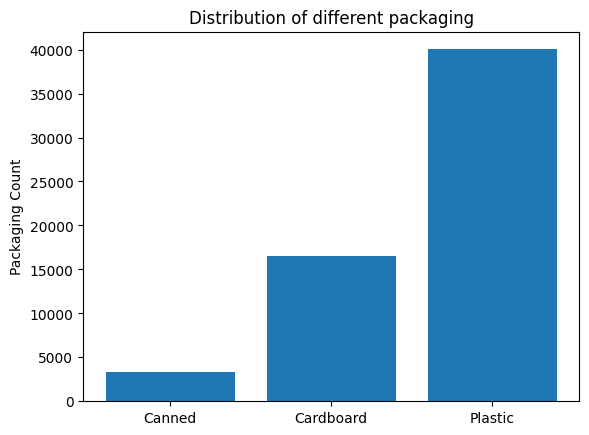

In [111]:
plt.title("Distribution of different packaging")
plt.bar(range(3), [num_canned,num_cardboard,num_plastic])
plt.xticks(range(3), ["Canned", "Cardboard", "Plastic"])
plt.ylabel("Packaging Count")
plt.show()

We can see that __plastic__ is definitely the predominant type of packaging in France - around double the amount of the other two categories combined.<br><br>
But that doesn't tell us much. What we can do, however is see whether these different types of packaging affect the nutrition score. Let's plot a histogram of the distributions of the nutrition scores across different packaging types.<br><br> Also, according to the french nutri-score system, the healthier products should have values close to 0.

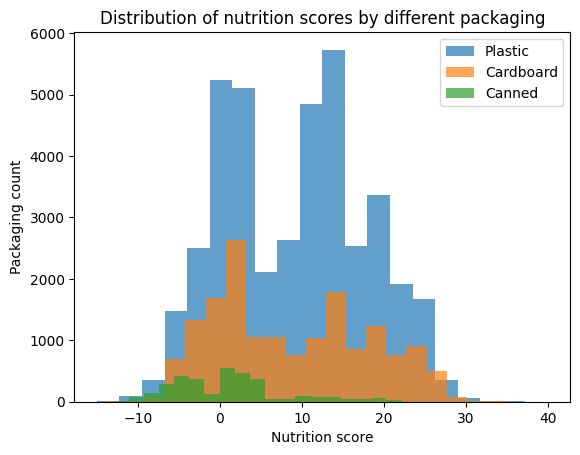

In [112]:
plt.title("Distribution of nutrition scores by different packaging")
plt.ylabel("Packaging count")
plt.xlabel("Nutrition score")
plt.hist(products_plastic["nutrition_score"],bins=20,alpha=0.7)
plt.hist(products_cardboard["nutrition_score"],bins=20,alpha=0.7)
plt.hist(products_canned["nutrition_score"],bins=20,alpha=0.7)
plt.legend(["Plastic", "Cardboard", "Canned"])
plt.show()

### Analyzing the additive count

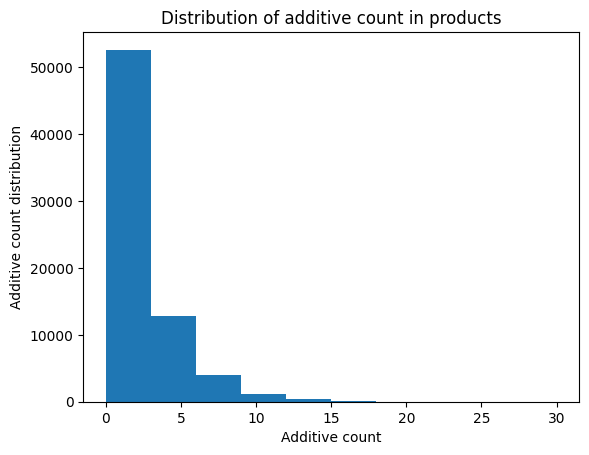

In [113]:
plt.title("Distribution of additive count in products")
plt.xlabel("Additive count")
plt.ylabel("Additive count distribution")
plt.hist(world_food_data_df["additives_n"])
plt.show()

In [114]:
world_food_data_df["additives_n"].unique()

array([ 0,  5,  3,  1,  4,  2, 11,  8, 10,  7,  9,  6, 13, 12, 14, 15, 16,
       17, 18, 21, 30, 20, 22, 19, 26])

Let's take a look at what part of the french products actually contain additives. I'm going to apply grouping on the `contains_additives` column and change the index names for clarity. There should be only two classes here.


In [115]:
products_with_additives = world_food_data_df["contains_additives"].value_counts()

products_with_additives


contains_additives
1    43100
0    27991
Name: count, dtype: int64

In [116]:
products_with_additives.index = ["don't contain additives", "contain additives"]


In [117]:
def plot_pie_on_grouped_data(grouped_data,title,explode):
    plt.gca().set_aspect("equal")
    plt.pie(grouped_data,labels=grouped_data.index, autopct = "%.2f%%",explode=explode,radius=1)
    plt.title(title)
    plt.show()

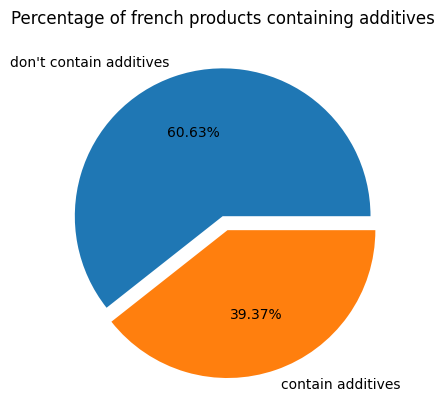

In [118]:
plot_pie_on_grouped_data(products_with_additives,"Percentage of french products containing additives",(0,0.1))

It seems that there are actually more french products that contain additives. That's interesting but does that really affect the nutrition value?<br><br>
Let's group the additive column by nutrition grade and find out!<br><br>
The grouped dataframe here should be of size __5__, one group for each grade `('A','B','C','D','E')`.

In [119]:
additives_by_grade=world_food_data_df["additives_n"].groupby(world_food_data_df["nutrition_grade_fr"])

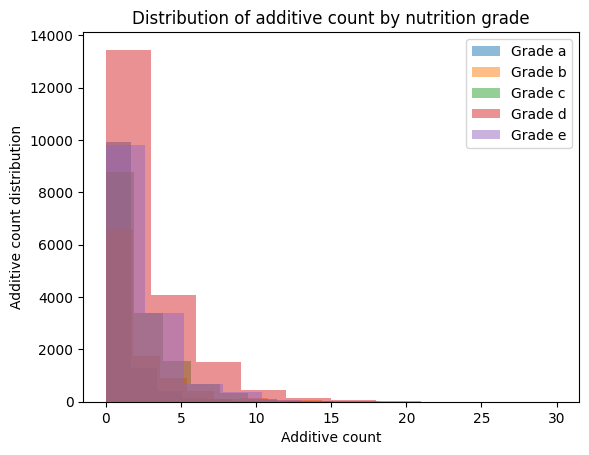

In [120]:
for additive, grade in additives_by_grade:
    plt.hist(grade, label = "Grade {}".format(additive), alpha = 0.5)
plt.title("Distribution of additive count by nutrition grade")
plt.xlabel("Additive count")
plt.ylabel("Additive count distribution")
plt.legend()
plt.show()

### Analyzing the palm oil ingredient count

In [121]:
palm_oil_group=world_food_data_df["ingredients_from_palm_oil_n"].value_counts()
palm_oil_group

ingredients_from_palm_oil_n
0    67055
1     4036
Name: count, dtype: int64

In [122]:
palm_oil_group.index=["palm oil absent","palm oil present"]

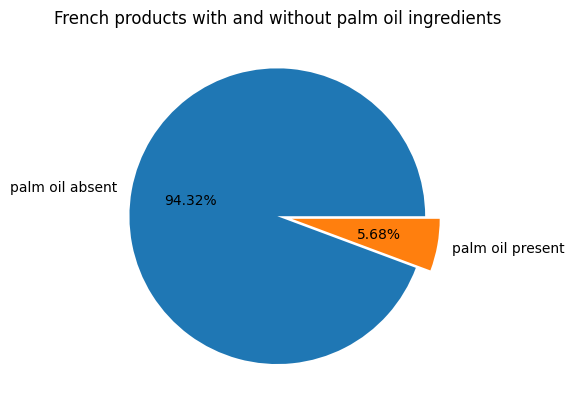

In [123]:
plot_pie_on_grouped_data(palm_oil_group,"French products with and without palm oil ingredients",(0,0.1))

### Analyzing the product categories

In [124]:
num_products_by_category=world_food_data_df["main_category"].value_counts().head(10)
num_products_by_category


main_category
plant-based-foods-and-beverages    16585
sugary-snacks                      10286
beverages                           6766
dairies                             6184
meats                               3790
groceries                           3655
fresh-foods                         2912
meals                               2486
salty-snacks                        2052
fruit-juices                        1688
Name: count, dtype: int64

In [125]:
def plot_barh_on_grouped_data(grouped_data,title,y_label,fig_size):
    plt.figure(figsize = fig_size)
    plt.title(title)
    plt.ylabel(y_label)
    plt.barh(range(len(grouped_data)), grouped_data)
    plt.yticks(list(range(len(grouped_data))), grouped_data.index)
    plt.show()

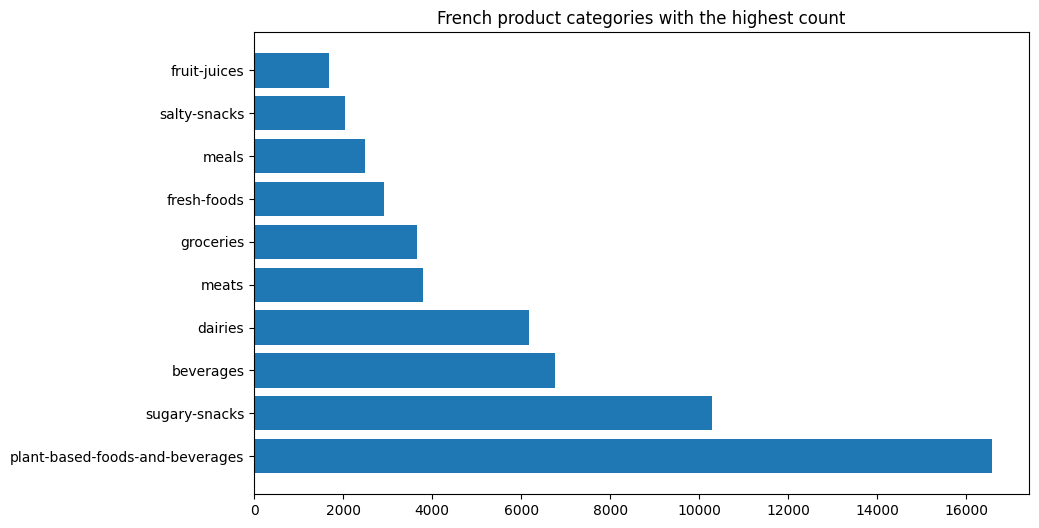

In [126]:
plot_barh_on_grouped_data(num_products_by_category,"French product categories with the highest count","",(10,6))

In [127]:
grades_by_category=world_food_data_df.main_category.groupby(world_food_data_df.nutrition_grade_fr).count()
grades_by_category

nutrition_grade_fr
a    11943
b    10070
c    14936
d    19745
e    14397
Name: main_category, dtype: int64

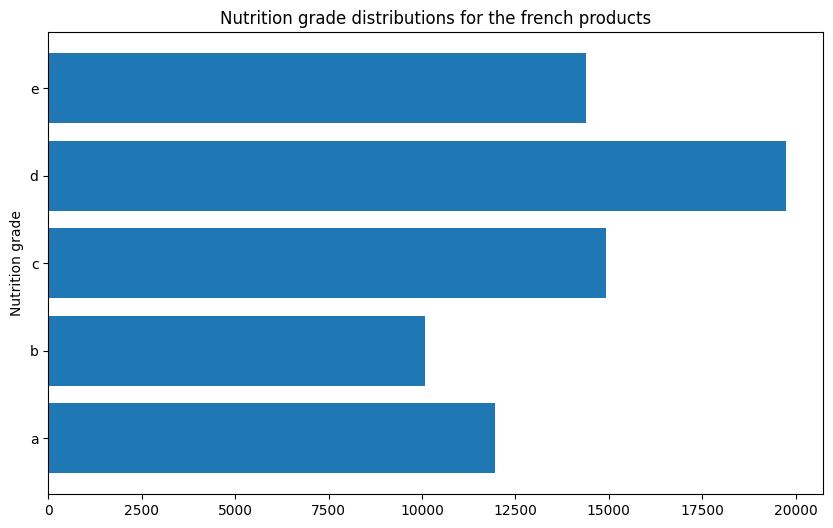

In [128]:
plot_barh_on_grouped_data(grades_by_category,"Nutrition grade distributions for the french products","Nutrition grade",(10,6))

## Step 3 - Comparing french beverages to Starbucks beverages

In [129]:
french_beverages=world_food_data_df[["product_name","fat_g","carbohydrates_g","proteins_g"]].loc[world_food_data_df["main_category"]=="beverages"]
starbucks_beverages=starbucks_data_df[["product_name","beverage_prep","fat_g","carbohydrates_g","proteins_g"]]

In [130]:
print(starbucks_beverages.dtypes)
print(starbucks_beverages.head())


product_name        object
beverage_prep       object
fat_g              float64
carbohydrates_g    float64
proteins_g         float64
dtype: object
    product_name      beverage_prep  fat_g  carbohydrates_g  proteins_g
0  Brewed Coffee              Short    0.1              5.0         0.3
1  Brewed Coffee               Tall    0.1             10.0         0.5
2  Brewed Coffee             Grande    0.1             10.0         1.0
3  Brewed Coffee              Venti    0.1             10.0         1.0
4    Caffè Latte  Short Nonfat Milk    0.1             75.0         6.0


In [131]:
starbucks_beverages.corr(numeric_only=True)

,fat_g,carbohydrates_g,proteins_g
fat_g,1.00000,0.450980,0.550850
carbohydrates_g,0.45098,1.000000,0.410629
proteins_g,0.55085,0.410629,1.000000


In [132]:
french_beverages.corr(numeric_only=True)

,fat_g,carbohydrates_g,proteins_g
fat_g,1.000000,0.058448,0.250706
carbohydrates_g,0.058448,1.000000,0.084138
proteins_g,0.250706,0.084138,1.000000


In [133]:
print("Number of french beverages:{} , Number of Starbucks beverages:{}".format(french_beverages.shape[0],
                                                                               starbucks_beverages.shape[0]))

Number of french beverages:6766 , Number of Starbucks beverages:242


In [134]:
print("Number of unique french beverages:{}, Number of unique Starbucks beverages:{}".format(len(french_beverages.product_name.unique()),
                                                                                             len(starbucks_beverages.product_name.unique())))

Number of unique french beverages:5531, Number of unique Starbucks beverages:33


When we print the shapes and number of unique products in the two dataframes, we see that the french products are a lot more and have a larger variance. So the difference in correlations in the two dataframes isn't surprising.<br><br>
So what can we do in order to make an accurate comparison between the number of nutrients in the two dataframes?
What I've done is write a function which does the following:
 1. Takes three parameters - __the two dataframes and number of iterations (experiments to apply sampling)__
 2. Switches the two dataframes if the `larger_df` has a smaller size, in order to get an accurate representation
 3. Samples nutrient values __equal to the size of the smaller dataframe__ for the __larger__ dataframe
 4. Sums over __the sampled__ values and acquires the total sum of nutrients for a sample of the __larger__ dataframe
 5. Sums over __all__ nutrients in the __smaller__ dataframe
 6. Prints these sums
 7. Prints the percentage of nutrients contained in a single sample of the __larger__ dataframe
 8. Prints the __mean total percentage__ of nutrients in the __larger__ dataframe across all samples
 
In our case the __larger__ dataframe will always be the french products dataframe and I expect that a sampled sum of these nutrients will always be less than the total sum of fast food nutrients, so I'm going to create this function based on that assumption.

The following will allow us to see exactly what is the difference in nutrition between the two dataframes.

In [135]:
def extract_mean_total_nutrients(larger_df,smaller_df,num_iterations):
    total_sum=0
    larger_df_copy=larger_df.copy()
    smaller_df_copy=smaller_df.copy()
    
    #Check if the larger dataframe is actually given as the second parameter and switch the dataframes
    if larger_df.shape[0] < smaller_df.shape[0]:
        larger_df=smaller_df_copy
        smaller_df=larger_df_copy
        
    for i in range(num_iterations):
        total_nutrients_larger = round(larger_df.carbohydrates_g.sample(len(smaller_df)).sum() + larger_df.proteins_g.sample(len(smaller_df)).sum() + larger_df.fat_g.sample(len(smaller_df)).sum())
        total_nutrients_smaller = round(smaller_df.carbohydrates_g.sum() + smaller_df.proteins_g.sum() + smaller_df.fat_g.sum())
        print("Sample ",i+1)
        print("Total sampled nutrients (Larger dataframe):{} , Total nutrients (Smaller dataframe):{}".format(total_nutrients_larger,
                                                                                        total_nutrients_smaller))
        sample_per=total_nutrients_larger/total_nutrients_smaller*100
        print("Total % of nutrients in iteration for the larger dataframe:{:.2f}".format(sample_per))
        total_sum+=sample_per
    
    total_mean=total_sum/num_iterations
    print("\nMean total % of nutrients for the larger dataframe across all iterations:{:.2f}".format(total_mean))
    return total_mean

In [136]:
mean_result=extract_mean_total_nutrients(french_beverages,starbucks_beverages,10)

Sample  1
Total sampled nutrients (Larger dataframe):3346 , Total nutrients (Smaller dataframe):33579
Total % of nutrients in iteration for the larger dataframe:9.96
Sample  2
Total sampled nutrients (Larger dataframe):4139 , Total nutrients (Smaller dataframe):33579
Total % of nutrients in iteration for the larger dataframe:12.33
Sample  3
Total sampled nutrients (Larger dataframe):3818 , Total nutrients (Smaller dataframe):33579
Total % of nutrients in iteration for the larger dataframe:11.37
Sample  4
Total sampled nutrients (Larger dataframe):3853 , Total nutrients (Smaller dataframe):33579
Total % of nutrients in iteration for the larger dataframe:11.47
Sample  5
Total sampled nutrients (Larger dataframe):4063 , Total nutrients (Smaller dataframe):33579
Total % of nutrients in iteration for the larger dataframe:12.10
Sample  6
Total sampled nutrients (Larger dataframe):3605 , Total nutrients (Smaller dataframe):33579
Total % of nutrients in iteration for the larger dataframe:10.74

In [137]:
def get_max_product_values_by_category(dataframe,category):
    group_result=category.groupby(dataframe.product_name).max().sort_values(ascending=False).nlargest(10)
    return group_result

In [138]:
carb_heavy_french_beverages=get_max_product_values_by_category(french_beverages,french_beverages.carbohydrates_g)
carb_heavy_starbucks_beverages=get_max_product_values_by_category(starbucks_beverages,starbucks_beverages.carbohydrates_g)

In [139]:
carb_heavy_french_beverages

product_name
Sauce Dessert Au Caramel                  100.0
LE SIROP D'ERABLE                         100.0
Bio Agaven Dicksaft                       100.0
Sirop d'agave                             100.0
 Ginger drink                              99.0
Nesquik Sabor Fresa                        97.6
Bonbons durs Réglisse                      96.0
Infuselle Bonne Nuit                       96.0
Tisane bonne nuit                          96.0
Gyokuro Garden Green Tea 120GX5 Pieces     96.0
Name: carbohydrates_g, dtype: float64

In [140]:
filter_out_list = ['Sirop', 'SIROP', 'sirop', 'Agaven', 'agaven', 'AGAVEN',
                                                        'Dessert', 'DESSERT', 'dessert', 'Bonbons']
pattern='|'.join(filter_out_list)
french_beverages = french_beverages[~french_beverages.product_name.str.contains(pattern)]

In [141]:
carb_heavy_french_beverages=get_max_product_values_by_category(french_beverages,french_beverages.carbohydrates_g)

In [142]:
carb_heavy_french_beverages

product_name
 Ginger drink                                                     99.0
Nesquik Sabor Fresa                                               97.6
Infuselle Bonne Nuit                                              96.0
Gyokuro Garden Green Tea 120GX5 Pieces                            96.0
Tisane bonne nuit                                                 96.0
Infuselle Après-Repas                                             96.0
Thé Citron Boisson Instantanée                                    95.0
Bio Drink Antioxydant Goût Fruits Rouges - 500 G - Punch Power    95.0
Thé & Citron                                                      94.9
Boisson Instantanée Thé Citron                                    94.7
Name: carbohydrates_g, dtype: float64

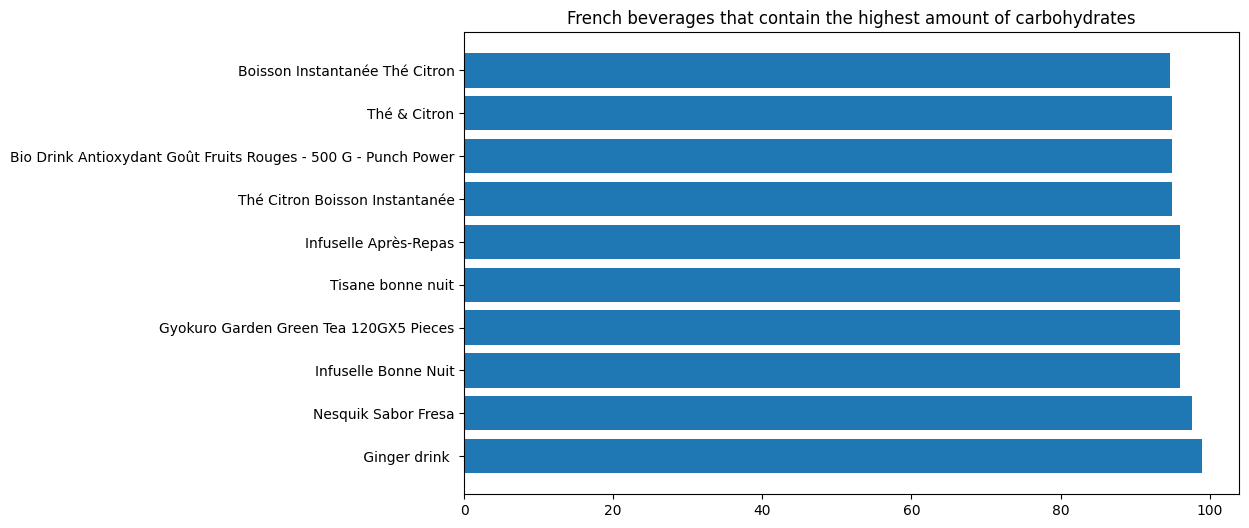

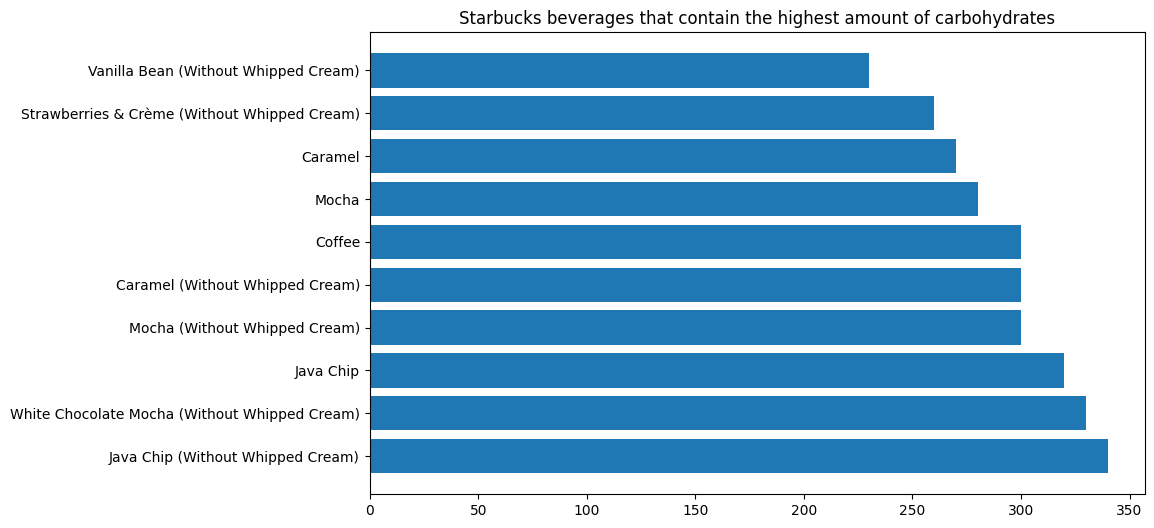

In [143]:
plot_barh_on_grouped_data(carb_heavy_french_beverages,"French beverages that contain the highest amount of carbohydrates","",(10,6))
plot_barh_on_grouped_data(carb_heavy_starbucks_beverages,"Starbucks beverages that contain the highest amount of carbohydrates","",(10,6))

In [144]:
print(round(carb_heavy_starbucks_beverages[0]/carb_heavy_french_beverages[4]))

4


/tmp/ipykernel_15915/797516978.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(round(carb_heavy_starbucks_beverages[0]/carb_heavy_french_beverages[4]))


## Step 4 - Comparing french meat to McDonalds meat 

We saw how the french beverages compare to fast food beverages. Now let's check out the french meat.<br><br>
Again I'm going to extract the products from a specific category along with the needed features, in this case the `meats` category and save them into `french_meat_data`.<br><br>To obtain the McDonalds meat products, first we'll take the categories `Beef & Pork` and `Chicken & Fish`. Afterwards we'll add the products from other categories, which contain the words `["Sausage","Bacon","Chicken","Steak"]`. Finally we'll filter out the ones labeled as `Fish`.

In [ ]:
french_meat_data = world_food_data_df[["product_name","fat_g","carbohydrates_g","proteins_g"]].loc[
    world_food_data_df["main_category"] == "meats"
]

cols_to_select = ["product_name","fat_g","carbohydrates_g","proteins_g"]

words_to_search = ["Sausage","Bacon","Chicken","Steak"]
pattern = '|'.join(words_to_search)

mcd_category_filter = mcdonalds_data_df[
    (mcdonalds_data_df["category"] == 'Beef & Pork') | 
    (mcdonalds_data_df["category"] == 'Chicken & Fish')
][["product_name","fat_g","carbohydrates_g","proteins_g"]]

# Lọc DataFrame 1 (theo category)
df1 = mcdonalds_data_df[cols_to_select].loc[
    (mcdonalds_data_df["category"] == 'Beef & Pork') |
    (mcdonalds_data_df["category"] == 'Chicken & Fish')
]

# Lọc DataFrame 2 (theo tên chứa pattern)
df2 = mcdonalds_data_df[cols_to_select].loc[
    mcdonalds_data_df.product_name.str.contains(pattern)
]

mcd_meat_data = pd.concat([df1, df2])

mcd_meat_data = mcd_meat_data[~mcd_meat_data["product_name"].isin(["Fish"])]

In [146]:
print("Number of french meat products:{} , Number of McDonalds meat products:{}".format(french_meat_data.shape[0],
                                                                               mcd_meat_data.shape[0]))

Number of french meat products:3790 , Number of McDonalds meat products:111


In [148]:
mcd_meat_data.corr(numeric_only=True)

,fat_g,carbohydrates_g,proteins_g
fat_g,1.000000,0.774488,0.772198
carbohydrates_g,0.774488,1.000000,0.752598
proteins_g,0.772198,0.752598,1.000000


In [150]:
french_meat_data.corr(numeric_only=True)

,fat_g,carbohydrates_g,proteins_g
fat_g,1.000000,0.011124,-0.102674
carbohydrates_g,0.011124,1.000000,-0.321887
proteins_g,-0.102674,-0.321887,1.000000


In [151]:
mean_result = extract_mean_total_nutrients(french_meat_data,mcd_meat_data,10)

Sample  1
Total sampled nutrients (Larger dataframe):4079 , Total nutrients (Smaller dataframe):10454
Total % of nutrients in iteration for the larger dataframe:39.02
Sample  2
Total sampled nutrients (Larger dataframe):3971 , Total nutrients (Smaller dataframe):10454
Total % of nutrients in iteration for the larger dataframe:37.99
Sample  3
Total sampled nutrients (Larger dataframe):4164 , Total nutrients (Smaller dataframe):10454
Total % of nutrients in iteration for the larger dataframe:39.83
Sample  4
Total sampled nutrients (Larger dataframe):4065 , Total nutrients (Smaller dataframe):10454
Total % of nutrients in iteration for the larger dataframe:38.88
Sample  5
Total sampled nutrients (Larger dataframe):4318 , Total nutrients (Smaller dataframe):10454
Total % of nutrients in iteration for the larger dataframe:41.30
Sample  6
Total sampled nutrients (Larger dataframe):4227 , Total nutrients (Smaller dataframe):10454
Total % of nutrients in iteration for the larger dataframe:40.4

In [152]:
fat_heavy_french_meat_products=get_max_product_values_by_category(french_meat_data,french_meat_data.fat_g)
fat_heavy_mcd_meat_products=get_max_product_values_by_category(mcd_meat_data,mcd_meat_data.fat_g)

In [153]:
fat_heavy_french_meat_products

product_name
Diced smoked cooking bacon with added water              73.0
Gratons Pressés                                          65.0
Sobrasada de Mallorca Picante Forte                      63.0
Sobrasada de Mallorca                                    61.0
Salami                                                   54.0
2 tranches de foie gras de canard entier du Sud-Ouest    53.3
Mini Tartinette                                          51.0
Chorizo fort pur porc au piment d'Espagne                50.2
Salami Danois                                            50.0
BiFi Cigare Bierworst                                    50.0
Name: fat_g, dtype: float64

In [154]:
fat_heavy_mcd_meat_products

product_name
Chicken McNuggets (40 piece)                         118.0
Chicken McNuggets (20 piece)                          59.0
Double Quarter Pounder with Cheese                    43.0
Bacon Clubhouse Burger                                40.0
Bacon Clubhouse Crispy Chicken Sandwich               38.0
Sausage Biscuit with Egg (Large Biscuit)              37.0
Steak, Egg & Cheese Bagel                             35.0
Sausage Biscuit with Egg (Regular Biscuit)            33.0
Premium McWrap Southwest Chicken (Crispy Chicken)     33.0
Premium Crispy Chicken Club Sandwich                  33.0
Name: fat_g, dtype: float64

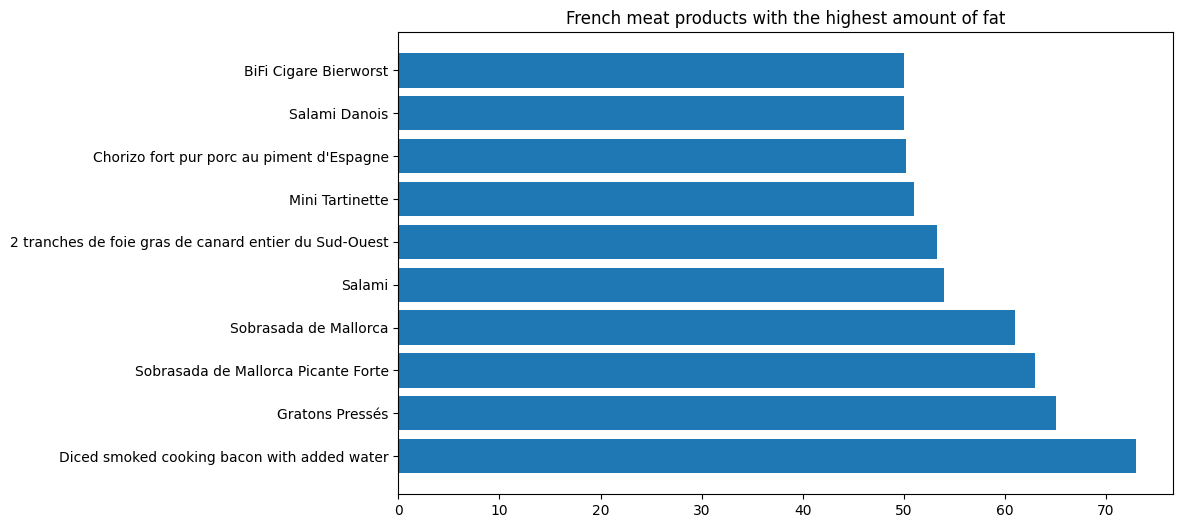

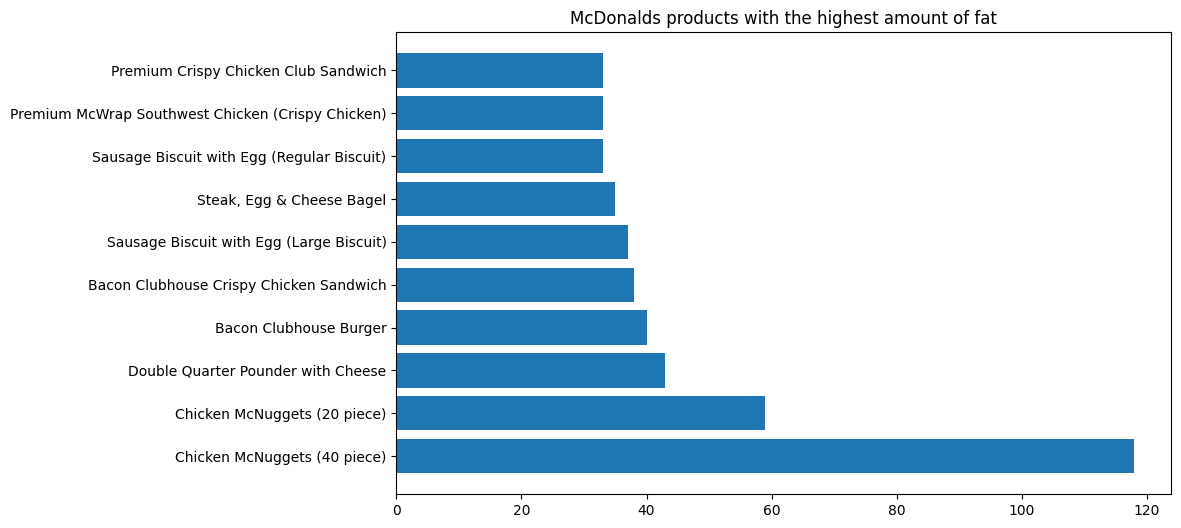

In [155]:
plot_barh_on_grouped_data(fat_heavy_french_meat_products,"French meat products with the highest amount of fat","",(10,6))
plot_barh_on_grouped_data(fat_heavy_mcd_meat_products,"McDonalds products with the highest amount of fat","",(10,6))

## Step 5 - Hypothesis testing

To find out whether the nutrients affect the nutrition grade, first I'm going to add it to the meat products.<br><br> Again, the grade column should have only __5__ possible values - 1 for each grade.

In [157]:
french_meat_data["grade"]=world_food_data_df["nutrition_grade_fr"]

In [158]:
french_meat_data.head()

,product_name,fat_g,carbohydrates_g,proteins_g,grade
44,British Beef Braising Steak,6.40,0.00,22.1,a
95,Spicy Boneless Chicken Wyngz,8.93,16.96,12.5,d
248,Half lamb leg bone in,12.30,0.00,19.0,b
259,British Sirloin Steak,12.70,0.00,21.6,b
361,British beef mince,4.70,0.50,31.0,b


Because I'll try out a few different hypotheses, I'll make a helper function to automate the process.<br><br>
It is going to accept a __dataframe__ and a __category__(in our case a nutrient) and the algorithm will be as follows:
 1. Group the selected category by nutrition grade.
 2. Print the mean values across every grade to get a feel of the difference in the grade values.
 3. Make three __ttests__ for the category with three different grade combinations.<br>In this case, we'll use the grades __A__,__B__ and __D__ (__D__ is the most common grade and I want to see how much the best grades differ from it).<br>I'll also assume `equal_var=False`, because we don't have overlapping data in the grouped dataframes.<br>__Student's t-test__ - Equal sample sizes, equal variance<br>__Welch's t-test__ - Unequal variances and unequal sample sizes.<br>__T-Test__ - Asserts that the two populations of data have equal means.<br> We'll also use a threshold value of __1%__ for these cases. This means that:<br>- If the `pvalue` of any of the three tests is <=__1%__, the $H_0$ hypothesis will be rejected - there will be significant differences in the data.<br>- Otherwise the $H_1$ hypothesis will be rejected - the differences in the data will not be significant.

In [159]:
def group_by_grade_and_make_hypotheses(dataframe,category):
    group_result=category.groupby(dataframe.grade)
    print("Category mean by:{}".format(group_result.mean()))
    category_grade_a=group_result.get_group("a")
    category_grade_b=group_result.get_group("b")
    category_grade_d=group_result.get_group("d")
    hyp_ab = ttest_ind(category_grade_a,category_grade_b,equal_var=False)
    hyp_bd = ttest_ind(category_grade_b,category_grade_d,equal_var=False)
    hyp_ad = ttest_ind(category_grade_a,category_grade_d,equal_var=False)
    print("A->B:{}".format(hyp_ab.pvalue))
    print("B->D:{}".format(hyp_bd.pvalue))
    print("A->D:{}".format(hyp_ad.pvalue))
    if hyp_ab.pvalue <= 0.01 and hyp_bd.pvalue <= 0.01 and hyp_ad.pvalue <= 0.01:
        print("The differences in grades are significant. Reject H0.")
    else:
        print("There's not enough evidence to reject H0. Don't accept or reject anything else.")
    return (hyp_ab,hyp_bd,hyp_ad)

In [160]:
(test_fat_result_ab,test_fat_result_bd,test_fat_result_ad)=group_by_grade_and_make_hypotheses(french_meat_data,french_meat_data.fat_g)

Category mean by:grade
a     3.932909
b     6.067296
c     5.918794
d    13.605347
e    29.307019
Name: fat_g, dtype: float64
A->B:9.497781765518207e-09
B->D:5.467045352081411e-73
A->D:6.227166038236639e-134
The differences in grades are significant. Reject H0.


## Step 6 - Draw a map of the first packaging locations of the french products

Just to be safe on our previous assumptions, I'll also draw a map, which will mark the places where the french products were packaged.<br> I'm going to do that using a helper drawing function and with the help of `Basemap`. The points to mark will be the values in the `[df_latitude,df_longitude]` columns. We'll also set some styles for the boundaries, coastlines and countries.

In [161]:
def draw_map_of_french_products(df_latitude,df_longitude,lat_lower_left,lon_lower_left,lat_upper_right,lon_upper_right,title):
    plt.figure(figsize = (12, 10))
    m = Basemap(projection = "merc", llcrnrlat = lat_lower_left, llcrnrlon = lon_lower_left, urcrnrlat = lat_upper_right, urcrnrlon = lon_upper_right)
    x, y = m(df_longitude.tolist(),df_latitude.tolist())
    m.plot(x,y,'o',markersize=1,color='red')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = "lightgreen", lake_color = "aqua")
    m.drawmapboundary(fill_color = "aqua")
    plt.title(title)
    plt.show()

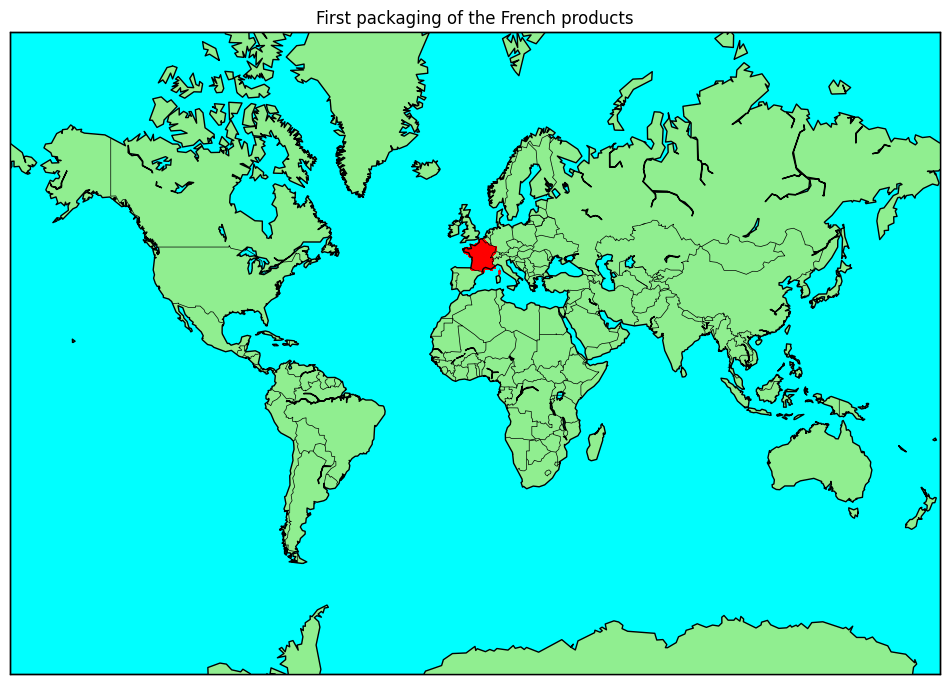

In [163]:
draw_map_of_french_products(world_food_data_df.fp_lat,world_food_data_df.fp_lon,-73,-180,80,180,"First packaging of the French products")

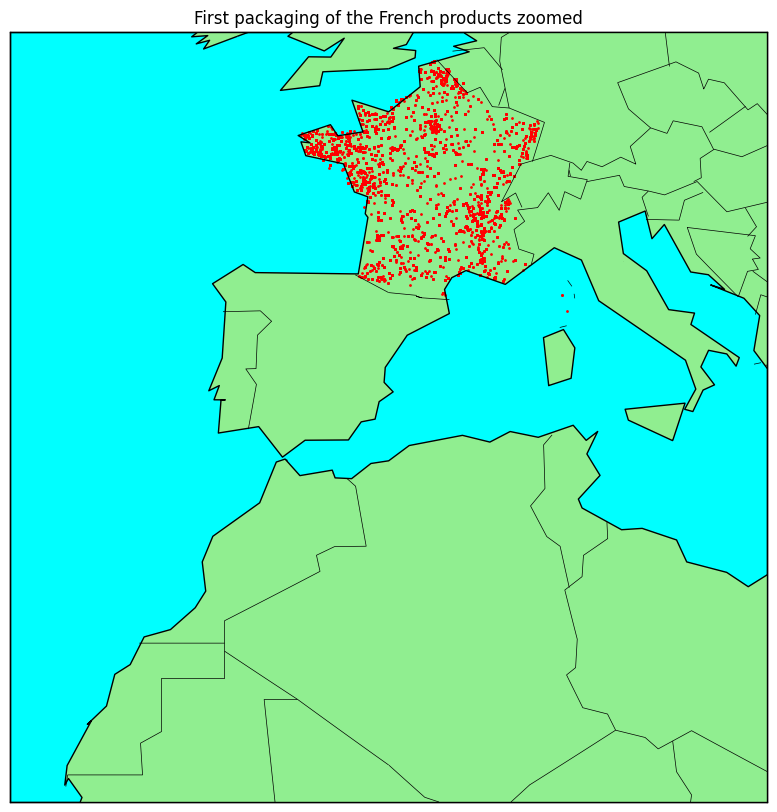

In [164]:
draw_map_of_french_products(world_food_data_df.fp_lat,world_food_data_df.fp_lon,20,-20,52,20,"First packaging of the French products zoomed")

This is indeed the territory of France and it would seem that the packaging coordinates are correct!

This concludes our Exploratory Data Analysis. We successfully managed to look into the nutrition values of the french products and compare our findings to fast food products and most importantly answer the questions that we laid out in the beginning. <br> I will present these answers in the conclusion, but first we'll move on to a bit of modelling before we end the project.